In [2]:
import pandas as pd 
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.cluster import KMeans
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.signal import savgol_filter
from time_stitches import *
from scipy.spatial.transform import Rotation as R
from features import *
from scipy.spatial.transform import Rotation as R
from my_plot_funcs import *
TOOLS = ["The Tweezers", "Needle Holder"]
CLUSTER_COLORS = ["green", "blue", "red"]
from functions import pd_2_numpy_and_segment, plot_segmented_signals
import seaborn as sns

from sklearn.cluster import DBSCAN
from parse_data import get_data_loss, get_np_mat_specific_cluste, get_list_derivatives_for_segments, get_features
import json

In [100]:
segments_time[4]

{'1': [478.8, 903.0],
 '2': [903.0, 1238.1],
 '3': [1238.1, 1567.6],
 '4': [1567.6, 1865.5],
 '5': [1865.5, 2122.6],
 '6': [2122.6, 2365.0],
 '7': [2365.0, 2596.2],
 '8': [2596.2, 2888.3]}

In [2]:
def cluster_data_points_DBSCAN(data, eps = 0.02, min_samples = 10 ):
    # Selecting a subset of data for clustering
    selected_data = data[:, 1:4]
    
    dbscan  = DBSCAN(eps=eps, min_samples=min_samples)
    
    # Fitting DBSCAN on the selected data
    dbscan.fit(selected_data)

    #get the labels
    labels = dbscan.labels_
    print(labels)
    
    # Initialize list to hold information about each cluster
    cluster_info = []
    # Iterating over each cluster to gather information
    print('Number of cluster unique:', len(np.unique(labels)))
    for i in range(len(np.unique(labels))):
        # Identifying indices of points belonging to the current cluster
        cluster_points_indices = np.where(labels == i)[0]
        # Selecting the actual points belonging to the current cluster
        cluster_points = selected_data[cluster_points_indices]
        
        
        # Adding information about the current cluster to the list
        cluster_info.append({
            'cluster_index': i,
            'cluster_points': cluster_points.tolist(), #à voir si pose problème après!!! Avant on avait un ndarray
            #'cluster_means': cluster_means,
            # Here 'cluster_indices_in_data' explicitly represents the indices of the points in the original dataset
            'cluster_indices_in_data': cluster_points_indices.tolist()
        })
    # Sorting the clusters based on the number of points they contain
    sorted_cluster_info = sorted(cluster_info, key=lambda x: len(x['cluster_points']), reverse=True)
    return sorted_cluster_info

In [3]:
#Settings and data loading for subject 1
subject = 1
target_subjects = [1]
i=0
dict_segment_time = segments_time[i]

tweezers_raw = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_raw.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')
needle_holder_raw = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_raw.csv')
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')

list_np_segmented_tw_raw = pd_2_numpy_and_segment(tweezers_raw, dict_segment_time)
list_np_segmented_tw_rec = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)
list_np_segmented_nh_raw = pd_2_numpy_and_segment(needle_holder_raw, dict_segment_time)
list_np_segmented_nh_rec = pd_2_numpy_and_segment(needle_holder_rec, dict_segment_time)

In [24]:
#Perform clustering
nh_clusters_all_sub = {}
sub_cluster = []
for i in range (8):
    print(i)
    ordered_info_cluster = cluster_data_points_DBSCAN(list_np_segmented_nh_rec[i], eps = 0.02, min_samples=200)
    sub_cluster.append(ordered_info_cluster)
#sub_cluster[s][c]{dict} s= stitches, c=cluster
nh_clusters_all_sub['Subject_1'] = sub_cluster

0
[0 0 0 ... 4 4 4]
Number of cluster unique: 10
1
[0 0 0 ... 0 0 0]
Number of cluster unique: 5
2
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
3
[0 0 0 ... 0 0 0]
Number of cluster unique: 4
4
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
5
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
6
[0 0 0 ... 0 0 0]
Number of cluster unique: 4
7
[0 0 0 ... 2 2 2]
Number of cluster unique: 4


In [29]:
#Perform clustering
tw_clusters_all_sub = {}
sub_cluster = []
for i in range (8):
    print(i)
    ordered_info_cluster = cluster_data_points_DBSCAN(list_np_segmented_tw_rec[i], eps = 0.02, min_samples=200)
    sub_cluster.append(ordered_info_cluster)
#sub_cluster[s][c]{dict} s= stitches, c=cluster
tw_clusters_all_sub['Subject_1'] = sub_cluster

0
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
1
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
2
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
3
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
4
[0 0 0 ... 0 0 0]
Number of cluster unique: 4
5
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
6
[0 0 0 ... 0 0 0]
Number of cluster unique: 3
7
[0 0 0 ... 0 0 0]
Number of cluster unique: 5


In [26]:
#save data
with open('nh_clustering_sub1.json', 'w') as f:
    json.dump(nh_clusters_all_sub, f)

In [30]:
#save data
with open('tw_clustering_sub1.json', 'w') as f:
    json.dump(tw_clusters_all_sub, f)

In [4]:
#load data
with open('nh_clustering_sub1.json', 'r') as f:
    nh_sub1_clusters = json.load(f)

In [5]:
#load data
with open('tw_clustering_sub1.json', 'r') as f:
    tw_sub1_clusters = json.load(f)

In [126]:
def plot_save_segmented_data_quaternions_g(subject_id, segment_id, data_tw, data_nh, data_loss_tw, data_loss_nh, save = True):
    directory = f"Plots/Signals/Quaternion Representation/"
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    fig, axs = plt.subplots(7, 2, sharex=True, figsize=(12, 10)) 
    # Plot data (tweezers) considering clustering
    axs[0, 0].set_title(f'Quat {TOOLS[0]} (Sub{subject_id}, Seg{segment_id+1}) - Loss {data_loss_tw}[%]', fontsize=FS_TITLE) 
    for i in range(7):
        palette_tw = sns.color_palette("deep", len(data_tw))
        #palette_tw = ['orange', 'blue', 'red', 'green', 'yellow', 'pink', 'purple']
        for c in range (len(data_tw)):
            axs[i,0].scatter(data_tw[c][:, 0], data_tw[c][:, i+1], facecolor=palette_tw[c], s=1)
        """axs[i, 0].scatter(data_tw[0][:, 0], data_tw[0][:, i+1], facecolor=CLUSTER_COLORS[0], s=1) 
        axs[i, 0].scatter(data_tw[1][:, 0], data_tw[1][:, i+1], facecolor=CLUSTER_COLORS[1], s=1) 
        axs[i, 0].scatter(data_tw[2][:, 0], data_tw[2][:, i+1], facecolor=CLUSTER_COLORS[2], s=1)""" 
        axs[i, 0].tick_params(axis='x', labelsize=FS_TICKS)  
        axs[i, 0].tick_params(axis='y', labelsize=FS_TICKS) 
    # Plot data (needle holder) considering clustering
    axs[0, 1].set_title(f'Quat {TOOLS[1]} (Sub{subject_id}, Seg{segment_id+1}) - Loss {data_loss_nh}[%]', fontsize=FS_TITLE) 
    for i in range(7):
        palette_nh = sns.color_palette("deep", len(data_nh))
        for c in range (len(data_nh)):
            axs[i,1].scatter(data_nh[c][:, 0], data_nh[c][:, i+1], facecolor=palette_nh[c], s=1)
        """axs[i, 1].scatter(data_nh[0][:, 0], data_nh[0][:, i+1], facecolor=CLUSTER_COLORS[0], s=1) 
        axs[i, 1].scatter(data_nh[1][:, 0], data_nh[1][:, i+1], facecolor=CLUSTER_COLORS[1], s=1) 
        axs[i, 1].scatter(data_nh[2][:, 0], data_nh[2][:, i+1], facecolor=CLUSTER_COLORS[2], s=1)"""        
        axs[i, 1].tick_params(axis='x', labelsize=FS_TICKS)  
        axs[i, 1].tick_params(axis='y', labelsize=FS_TICKS)   
    # Set labels
    axs[0, 0].set_ylabel(f'[m]', fontsize=FS_LABEL)
    axs[1, 0].set_ylabel(f'[m]', fontsize=FS_LABEL)
    axs[2, 0].set_ylabel(f'[m]', fontsize=FS_LABEL)
    axs[3, 0].set_ylabel(f'q_w', fontsize=FS_LABEL)
    axs[4, 0].set_ylabel(f'q_x', fontsize=FS_LABEL)
    axs[5, 0].set_ylabel(f'q_y', fontsize=FS_LABEL)
    axs[6, 0].set_ylabel(f'q_z', fontsize=FS_LABEL)
    axs[6, 0].set_xlabel(f'Time [s]', fontsize=FS_LABEL)
    axs[6, 1].set_xlabel(f'Time [s]', fontsize=FS_LABEL)
    plt.tight_layout()
    if save: plt.savefig(f"{directory}/S_{subject_id}_signals_{segment_id+1}.png", dpi=DPI_PNG)  
    if (PLOT_SHOW):
        plt.show()
    if save: plt.close(fig)

In [127]:
def plot_save_segmented_data_euler_g(subject_id, segment_id, data_tw, data_nh, data_loss_tw, data_loss_nh, save =True):
    directory = f"Plots/Signals/Euler Representation/"
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    fig, axs = plt.subplots(6, 2, sharex=True, figsize=(12, 10)) 
    # Plot data (tweezers) considering clustering
    axs[0, 0].set_title(f'Euler {TOOLS[0]} (Sub{subject_id}, Seg{segment_id+1}) - Loss {data_loss_tw}[%]', fontsize=FS_TITLE) 
    for i in range(6):
        palette_tw = sns.color_palette("deep", len(data_tw))
        for c in range (len(data_tw)):
            axs[i,0].scatter(data_tw[c][:, 0], data_tw[c][:, i+4], facecolor=palette_tw[c], s=1)
        """axs[i, 0].scatter(data_tw[0][:, 0], data_tw[0][:, i+1+4], facecolor=CLUSTER_COLORS[0], s=1) 
        axs[i, 0].scatter(data_tw[1][:, 0], data_tw[1][:, i+1+4], facecolor=CLUSTER_COLORS[1], s=1) 
        axs[i, 0].scatter(data_tw[2][:, 0], data_tw[2][:, i+1+4], facecolor=CLUSTER_COLORS[2], s=1)"""
        axs[i, 0].tick_params(axis='x', labelsize=FS_TICKS)  
        axs[i, 0].tick_params(axis='y', labelsize=FS_TICKS) 
    # Plot data (needle holder) considering clustering
    axs[0, 1].set_title(f'Euler {TOOLS[1]} (Sub{subject_id}, Seg{segment_id+1}) - Loss {data_loss_nh} [%]', fontsize=FS_TITLE) 
    for i in range(6):
        palette_nh = sns.color_palette("deep", len(data_nh))
        for c in range (len(data_nh)):
            axs[i,1].scatter(data_nh[c][:, 0], data_nh[c][:, i+1+4], facecolor=palette_nh[c], s=1)
        """axs[i, 1].scatter(data_nh[0][:, 0], data_nh[0][:, i+1+4], facecolor=CLUSTER_COLORS[0], s=1) 
        axs[i, 1].scatter(data_nh[1][:, 0], data_nh[1][:, i+1+4], facecolor=CLUSTER_COLORS[1], s=1) 
        axs[i, 1].scatter(data_nh[2][:, 0], data_nh[2][:, i+1+4], facecolor=CLUSTER_COLORS[2], s=1)"""       
        axs[i, 1].tick_params(axis='x', labelsize=FS_TICKS)  
        axs[i, 1].tick_params(axis='y', labelsize=FS_TICKS)     
    # Set labels
    axs[0, 0].set_ylabel(f'$x\,[m]$', fontsize=FS_LABEL)
    axs[1, 0].set_ylabel(f'$y\,[m]$', fontsize=FS_LABEL)
    axs[2, 0].set_ylabel(f'$z\,[m]$', fontsize=FS_LABEL)
    axs[3, 0].set_ylabel(f'$r_x [deg]$', fontsize=FS_LABEL)
    axs[4, 0].set_ylabel(f'$r_y [deg]$', fontsize=FS_LABEL)
    axs[5, 0].set_ylabel(f'$r_z [deg]$', fontsize=FS_LABEL)
    axs[5, 0].set_xlabel(f'Time [s]', fontsize=FS_LABEL)
    axs[5, 1].set_xlabel(f'Time [s]', fontsize=FS_LABEL)
    plt.tight_layout()
    if save: plt.savefig(f"{directory}/S_{subject_id}_signals_{segment_id+1}.png", dpi=DPI_PNG)  
    if (PLOT_SHOW):
        plt.show()
    if save: plt.close(fig)

In [128]:
def plot_segmented_signals_DBSCAN(subject_id, data_tw, data_nh, data_tw_raw, data_nh_raw, nh_cluster, tw_cluster, save =True):
    for s in range(2): #can go until 8, I put 2 so that I don't have all the plots
        #clusters_info_tw = cluster_data_points_DBSCAN(data_tw[s], eps = 20, min_samples=200)
        
        list_clusters_tw = [None] * len(tw_cluster['Subject_1'][s])#to change when run on several subjects
        for c in range(len(tw_cluster['Subject_1'][s])):
            indices = tw_cluster['Subject_1'][s][c]['cluster_indices_in_data']
            list_clusters_tw[c] = data_tw[s][indices]

        #clusters_info_nh = cluster_data_points_DBSCAN(data_nh[s], eps = 20, min_samples=200)
        list_clusters_nh = [None] * len(nh_cluster['Subject_1'][s])
        for c in range(len(nh_cluster['Subject_1'][s])):
            indices = nh_cluster['Subject_1'][s][c]['cluster_indices_in_data']
            list_clusters_nh[c] = data_nh[s][indices]

        #Plot function only consider 3 clusters, gives errors if less
        data_loss_tw = get_data_loss(subject_id, s, data_tw_raw, "tweezers")
        data_loss_nh = get_data_loss(subject_id, s, data_nh_raw, "needle holder")
        #Plot function only consider 3 clusters, gives errors if less
        plot_save_segmented_data_quaternions_g(subject_id, s, list_clusters_tw, list_clusters_nh, data_loss_tw, data_loss_nh, save=save)  
        plot_save_segmented_data_euler_g(subject_id, s, list_clusters_tw, list_clusters_nh, data_loss_tw, data_loss_nh, save =save)

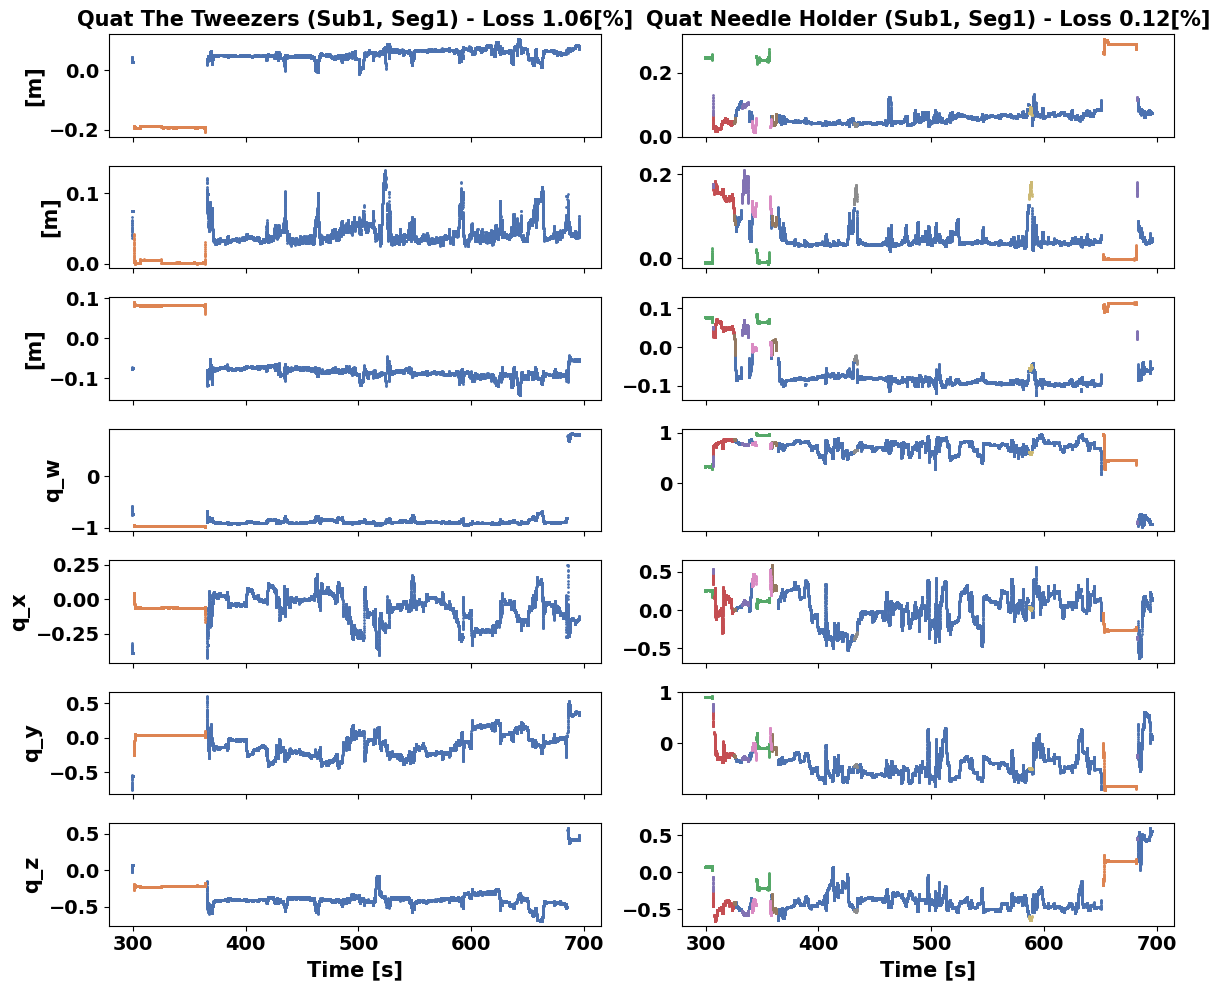

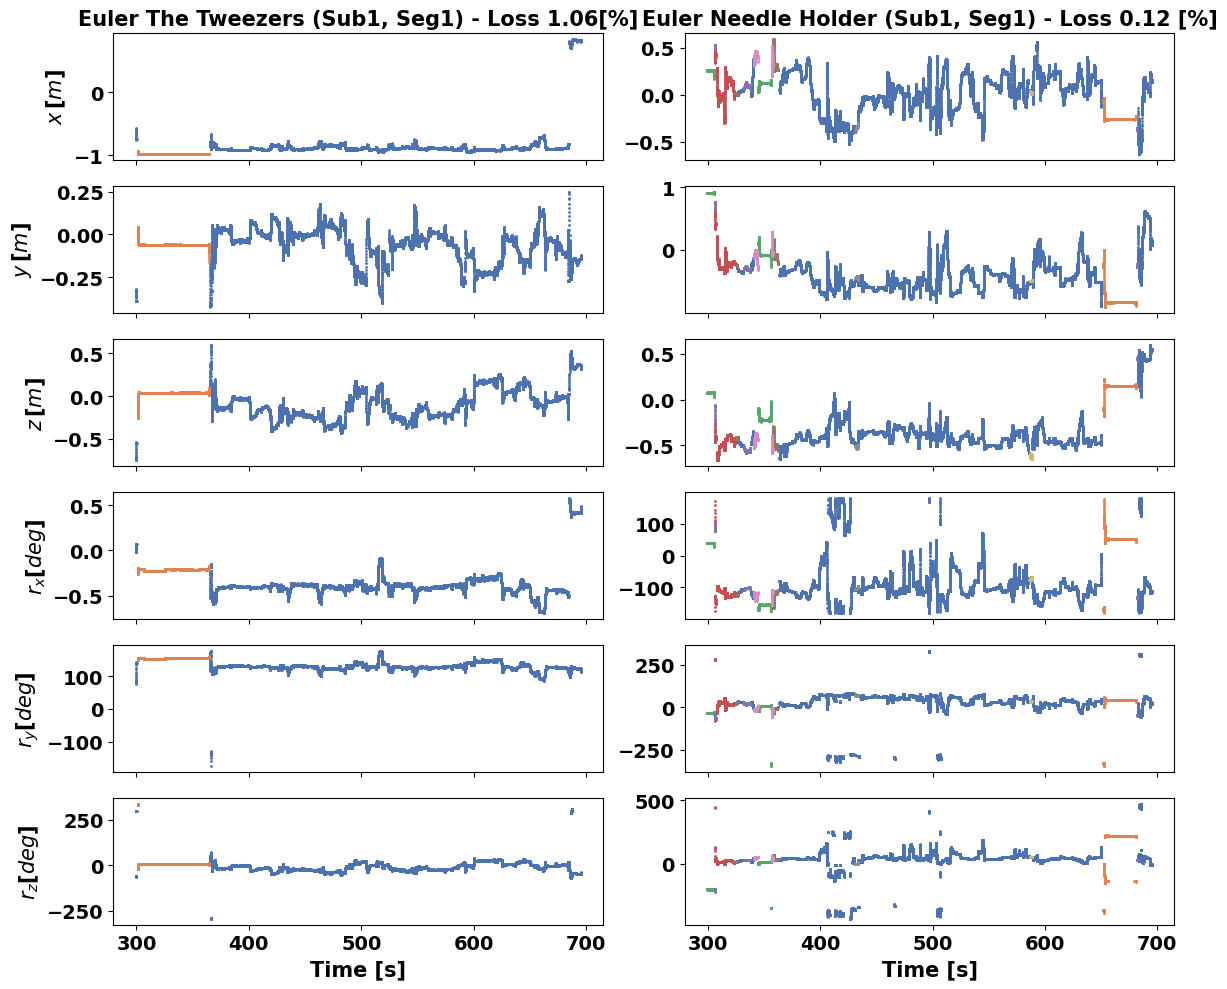

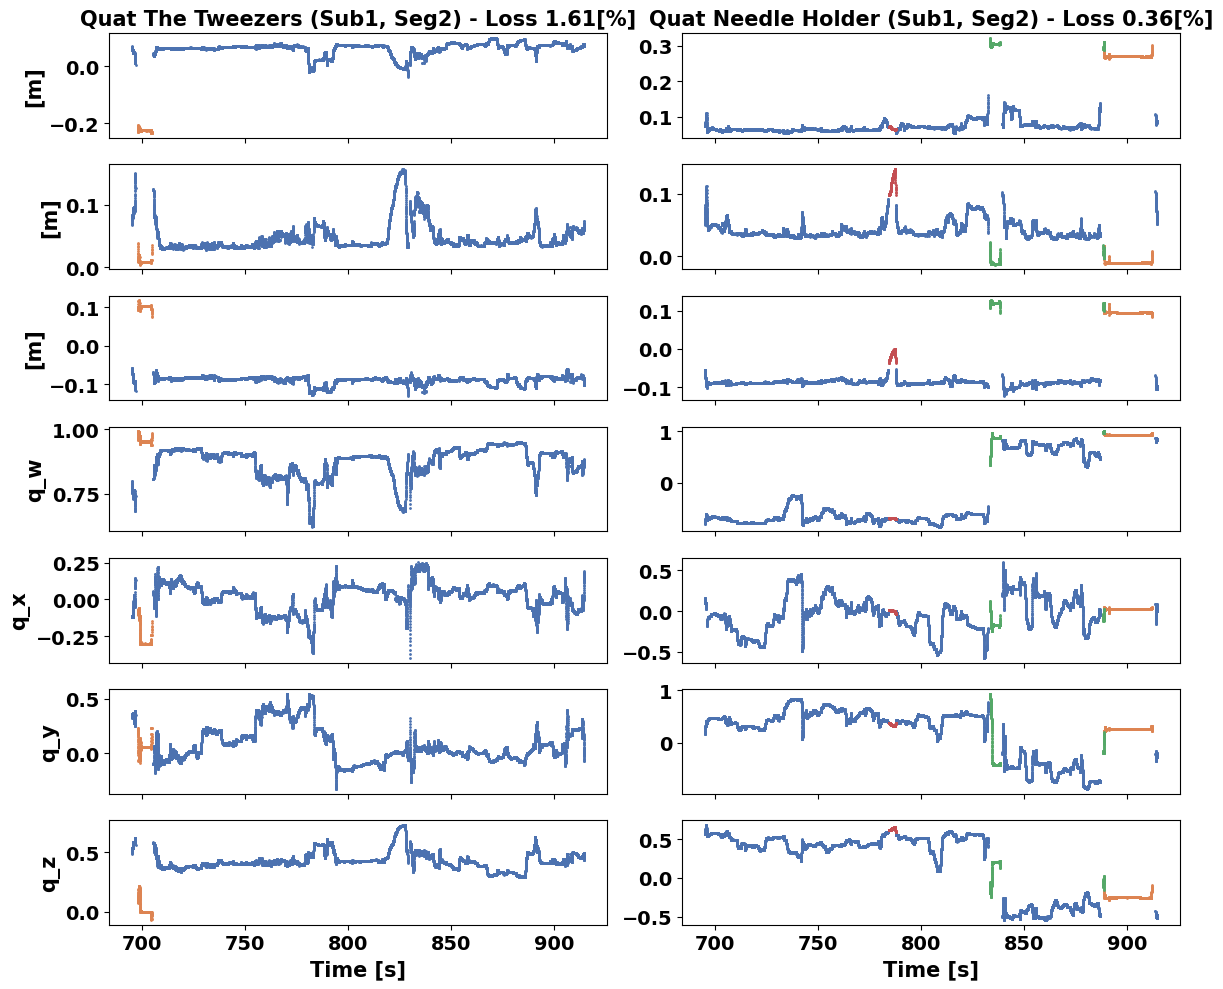

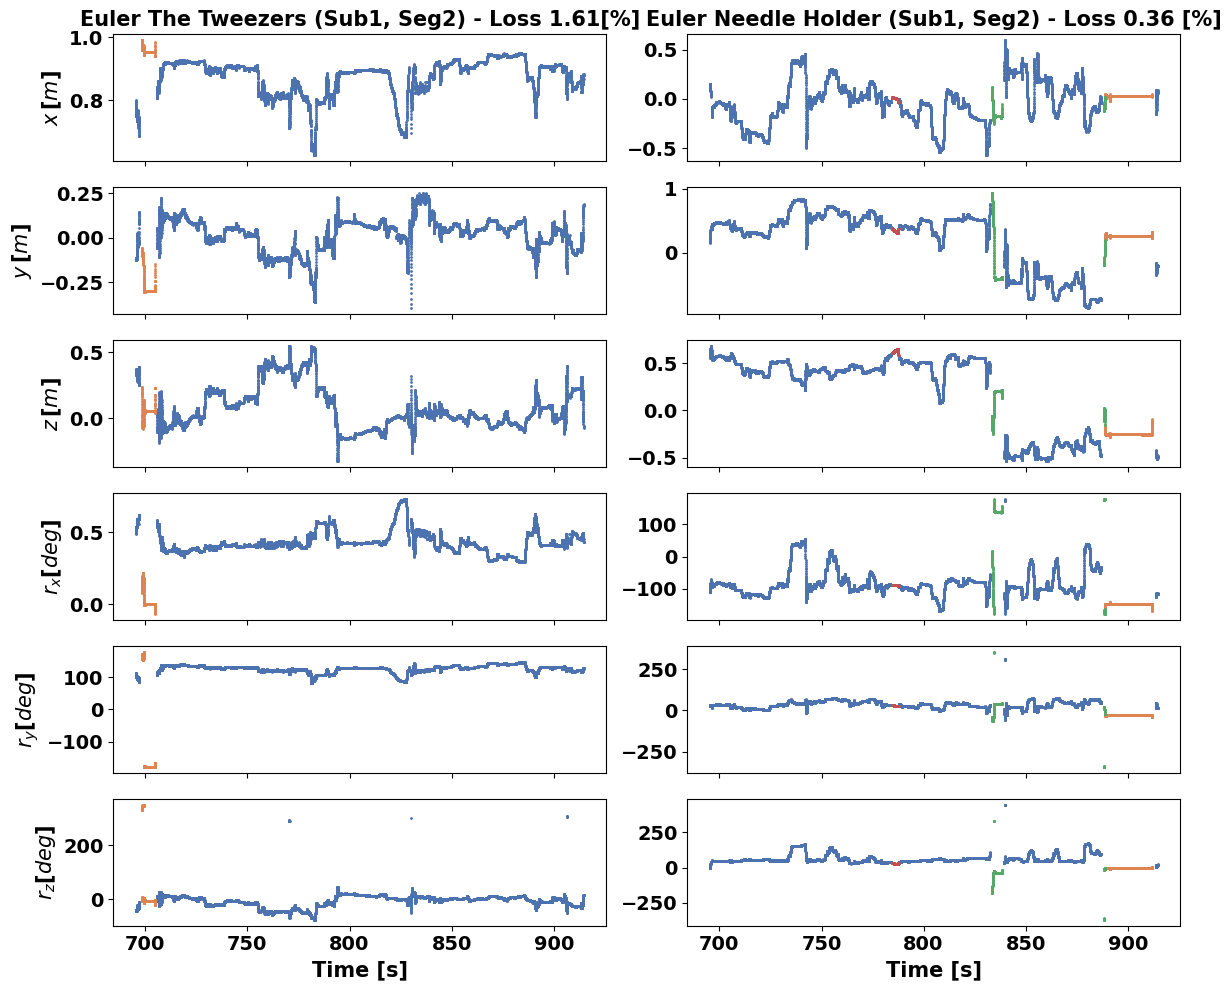

In [129]:
plot_segmented_signals_DBSCAN(1, list_np_segmented_tw_rec, list_np_segmented_nh_rec, list_np_segmented_tw_raw, list_np_segmented_nh_raw, nh_sub1_clusters, tw_sub1_clusters,save =False)


In [6]:
def plot_clustered_data_3D_g2(subject_id, tool_name, segment_id, cluster_info, data, ax, cluster_color):
    for i in range(len(cluster_info)):
        #color = colors[i % len(colors)]
        color = cluster_color[i]
        indices = cluster_info[i]['cluster_indices_in_data']
        ax.scatter(data[indices, 1], data[indices, 2], data[indices, 3], color=color, label=f'Cluster {i}', s=1)
    ax.set_xlabel('[m]')
    ax.set_ylabel('[m]')
    ax.set_zlabel('[m]')
    ax.set_title(f'Stitch {segment_id+1}')

In [24]:
def get_list_segments_with_clusters_DBSCAN(subject_id, tool_name, data, clusters_info, plot_enabled=True):
    list_segments_clusters = [None] * 8
    list_segments_clusters_info = [None] * 8
    
    if plot_enabled: fig = plt.figure(figsize=(15, 9))
    for s in range(8):
        ax = fig.add_subplot(2, 4, s+1, projection='3d')
        palette = sns.color_palette("deep", len(clusters_info['Subject_'+str(subject_id)][s]))
        plot_clustered_data_3D_g2(subject_id, tool_name, s, clusters_info['Subject_'+str(subject_id)][s], data[s], ax, palette)

        clusters = [None] * len(clusters_info['Subject_'+str(subject_id)][s])
        for c in range(len(clusters_info['Subject_'+str(subject_id)][s])):
            indices = clusters_info['Subject_'+str(subject_id)][s][c]['cluster_indices_in_data']
            clusters[c] = data[s][indices]
            # print(f"cluster:{c+1} - {len(clusters_info_tw[c]['cluster_points'])} - {list_clustered_tw[c].shape}")
        list_segments_clusters[s] = clusters #for each stitch gives segmented data corresponding to each cluster separated
        list_segments_clusters_info[s] = clusters_info['Subject_'+str(subject_id)][s] #for each stitch gives general cluster info
    
    if plot_enabled:
        fig.suptitle(f'3-D Scatter Plot of Clustered Data using DBSCAN ({tool_name})')
        plt.tight_layout()
        plt.show()

    return list_segments_clusters, list_segments_clusters_info

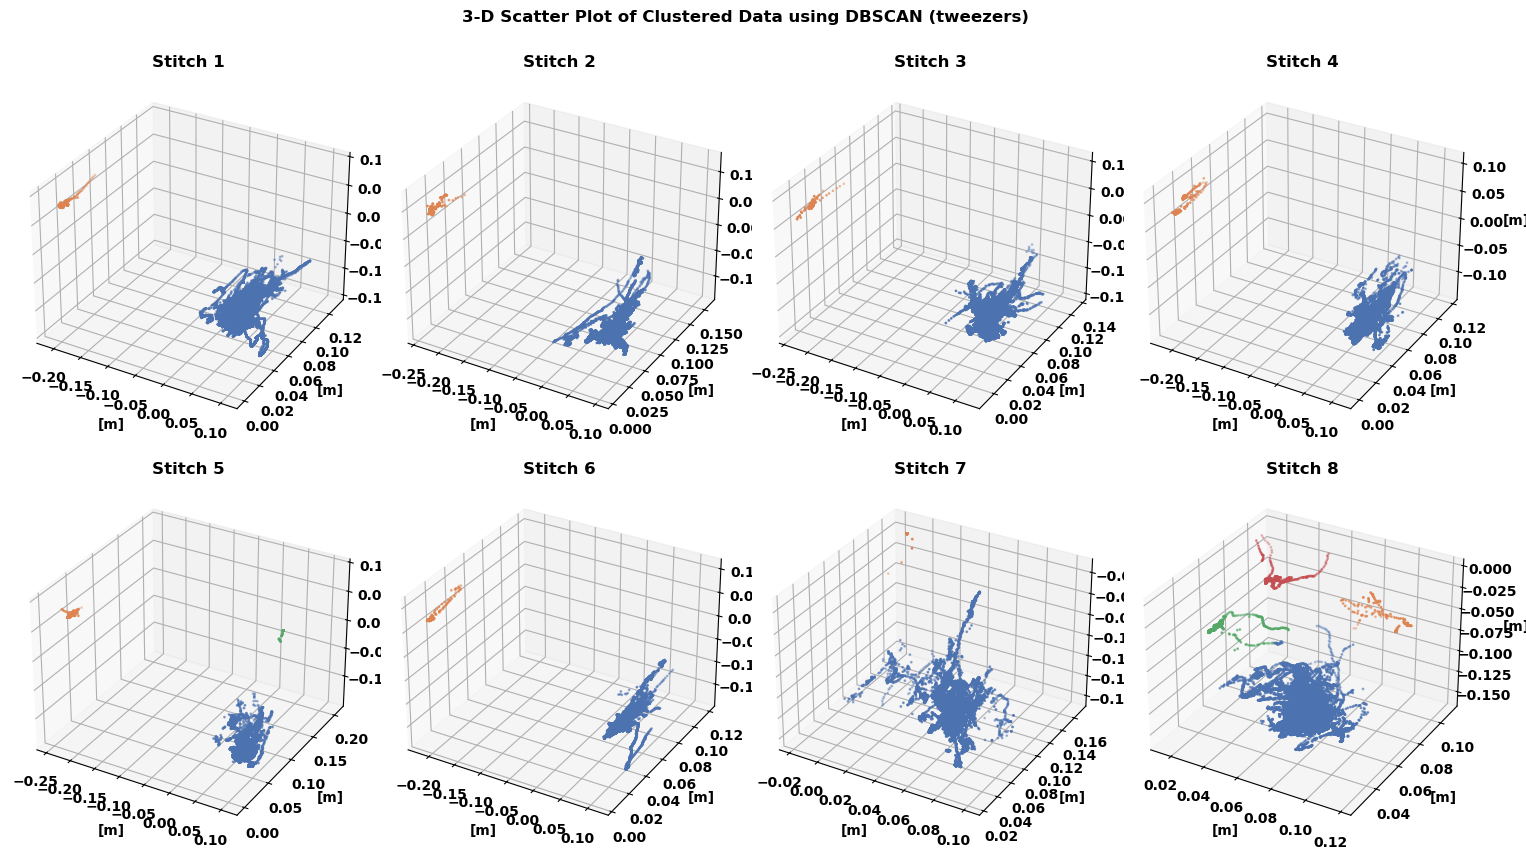

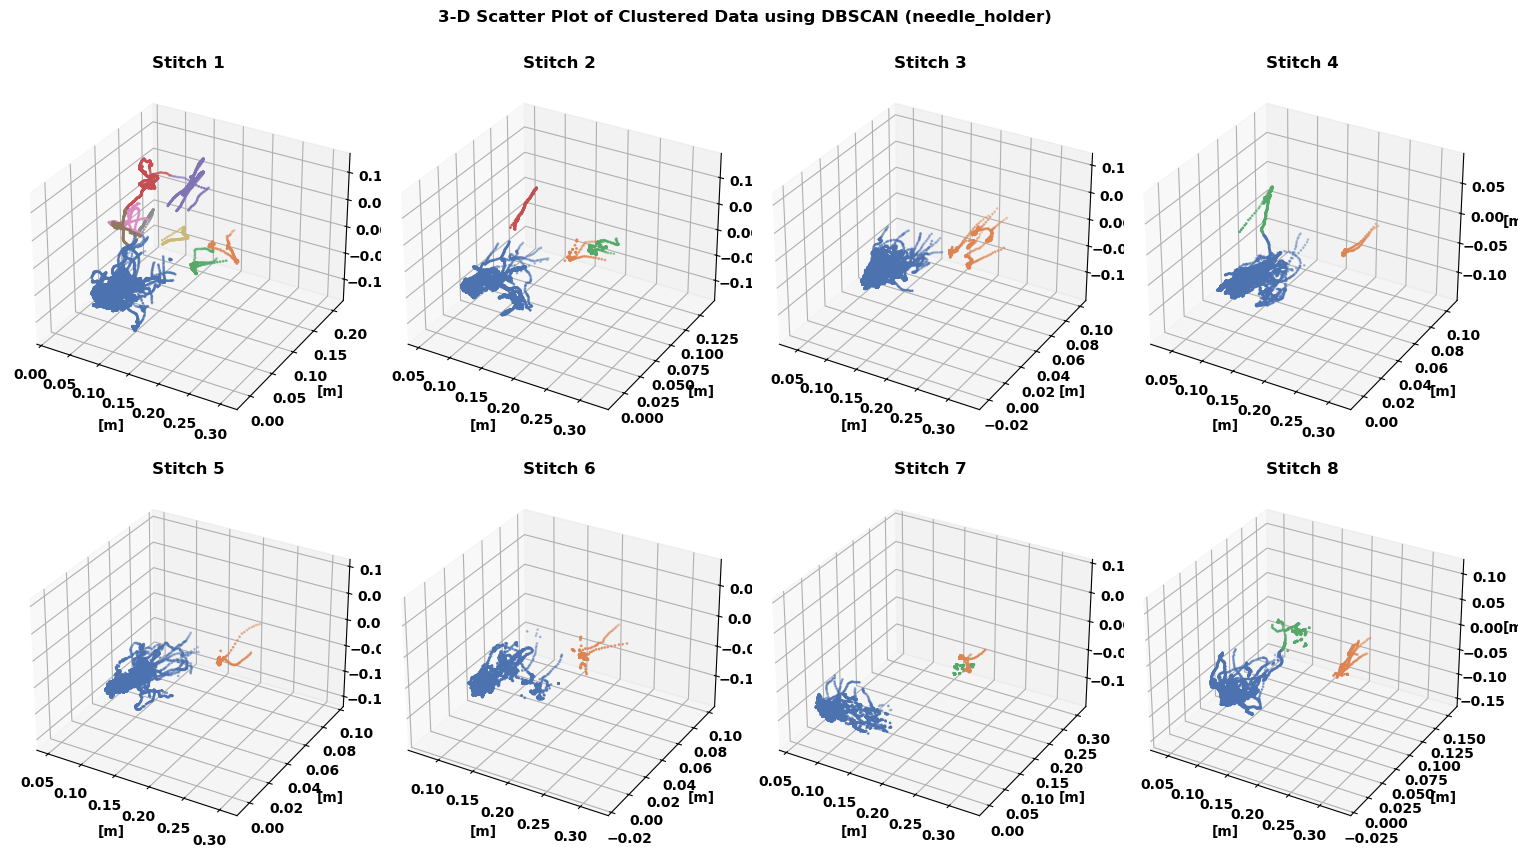

In [25]:
list_segments_with_clusters_tw, list_clusters_info_tw = get_list_segments_with_clusters_DBSCAN(1, "tweezers", list_np_segmented_tw_rec, tw_sub1_clusters)
list_segments_with_clusters_nh, list_clusters_info_nh = get_list_segments_with_clusters_DBSCAN(1, "needle_holder", list_np_segmented_nh_rec, nh_sub1_clusters)  

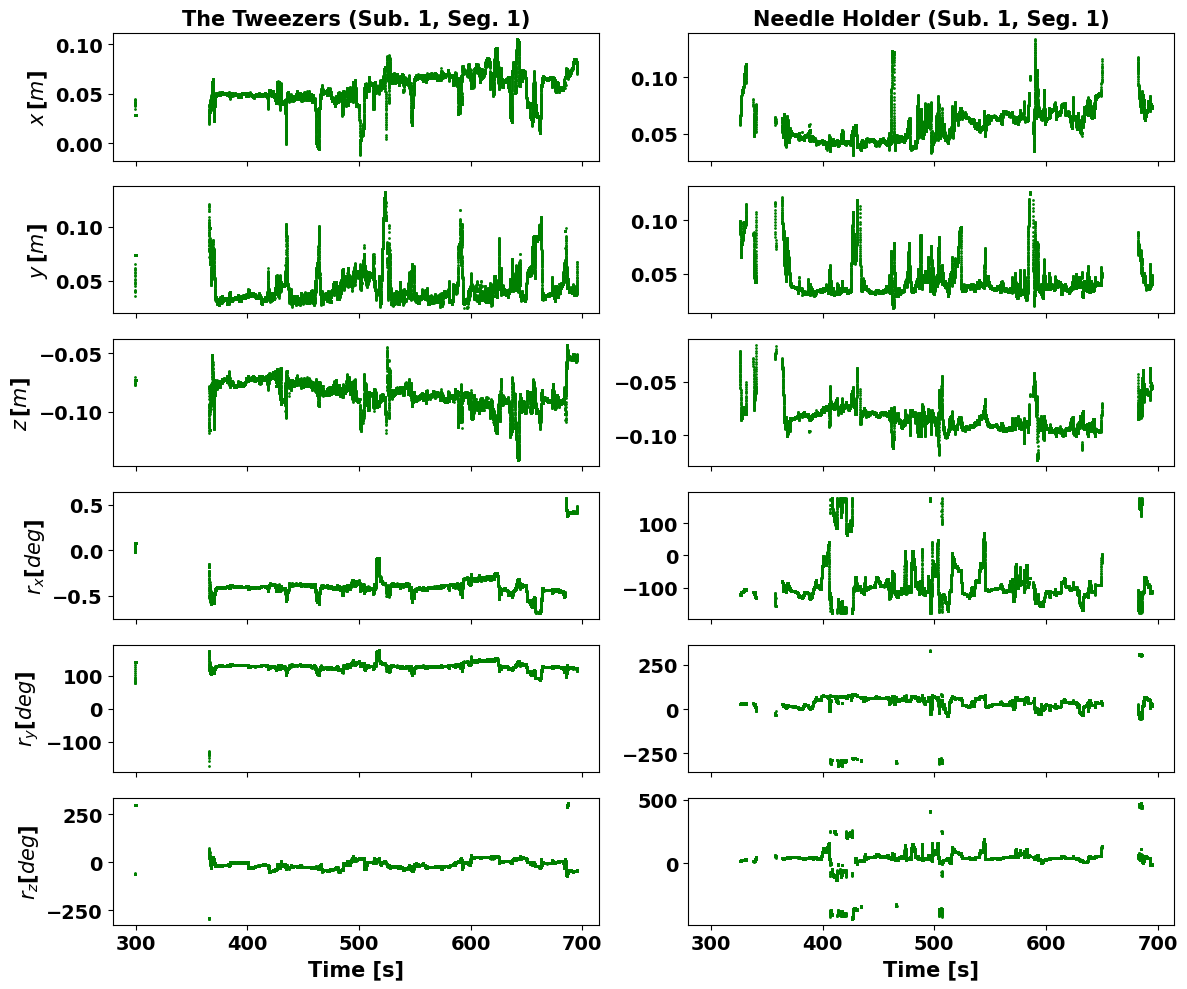

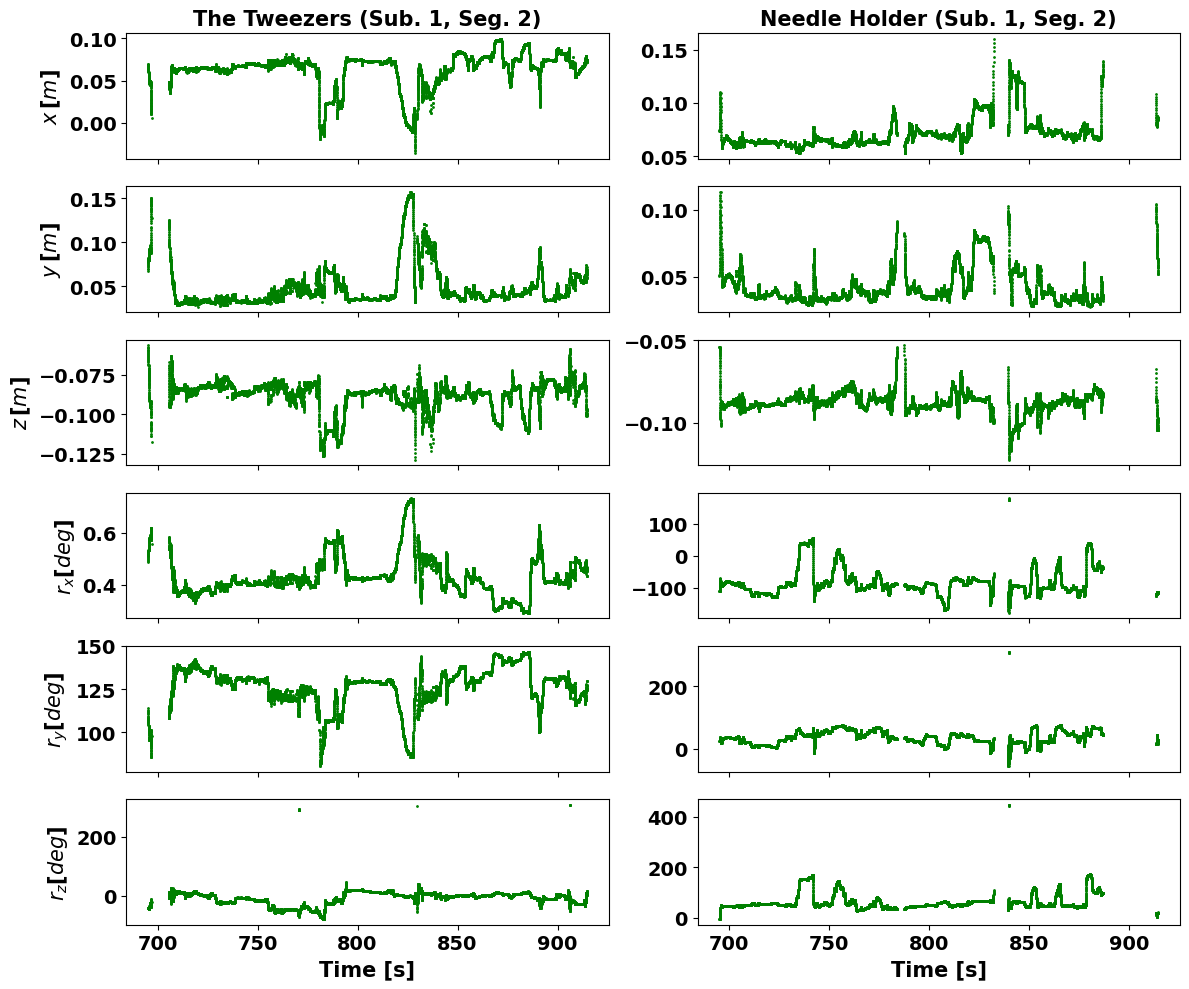

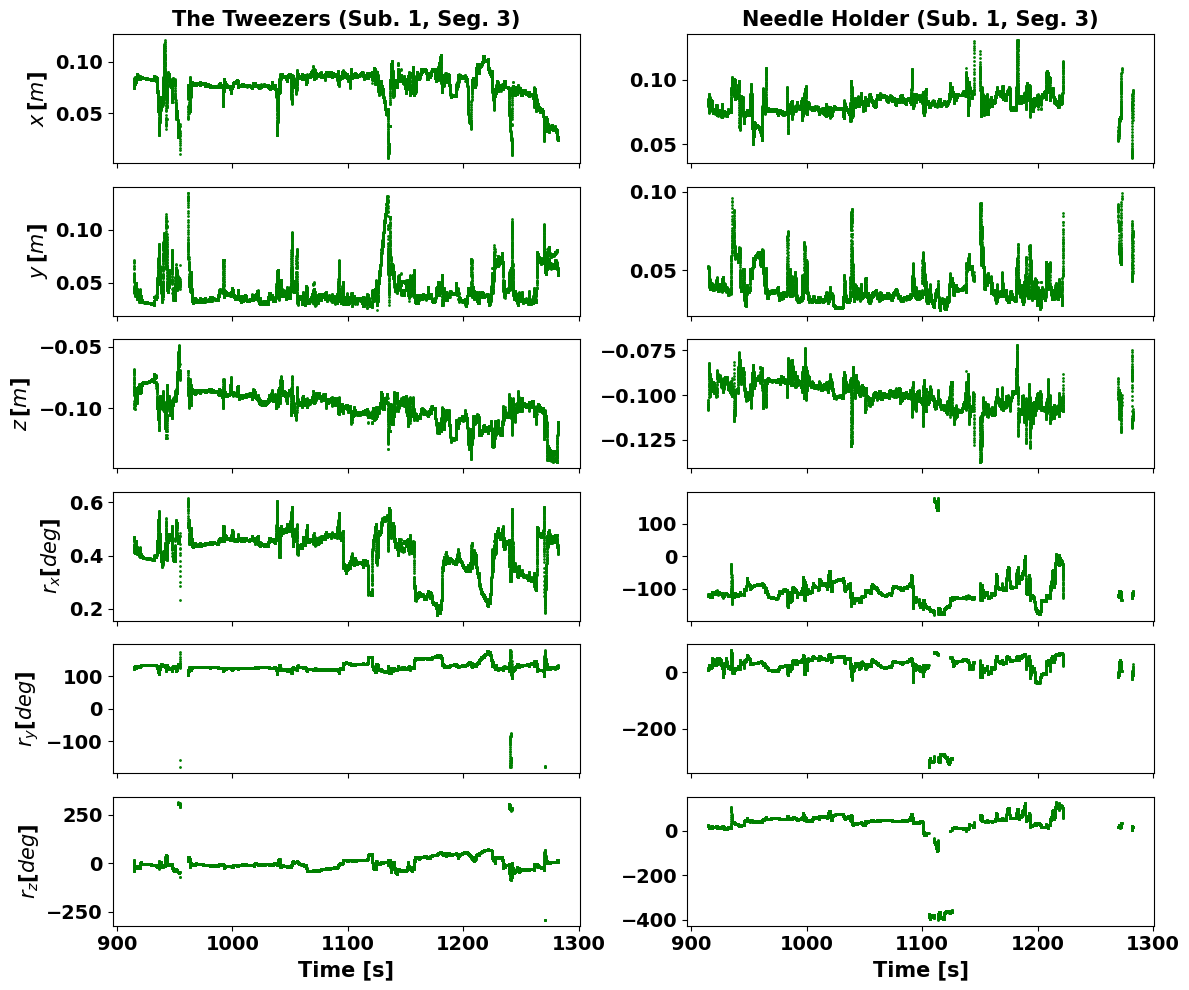

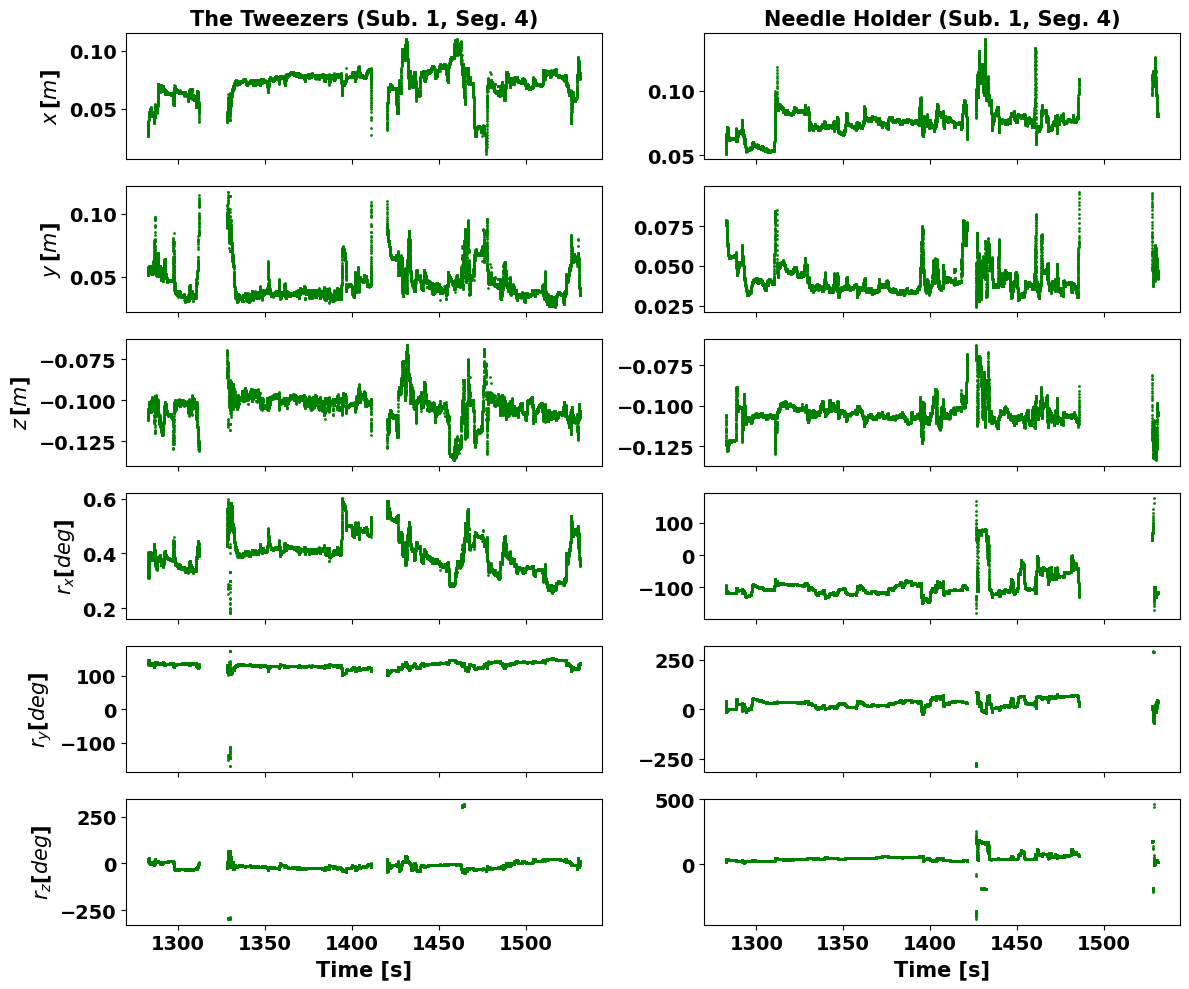

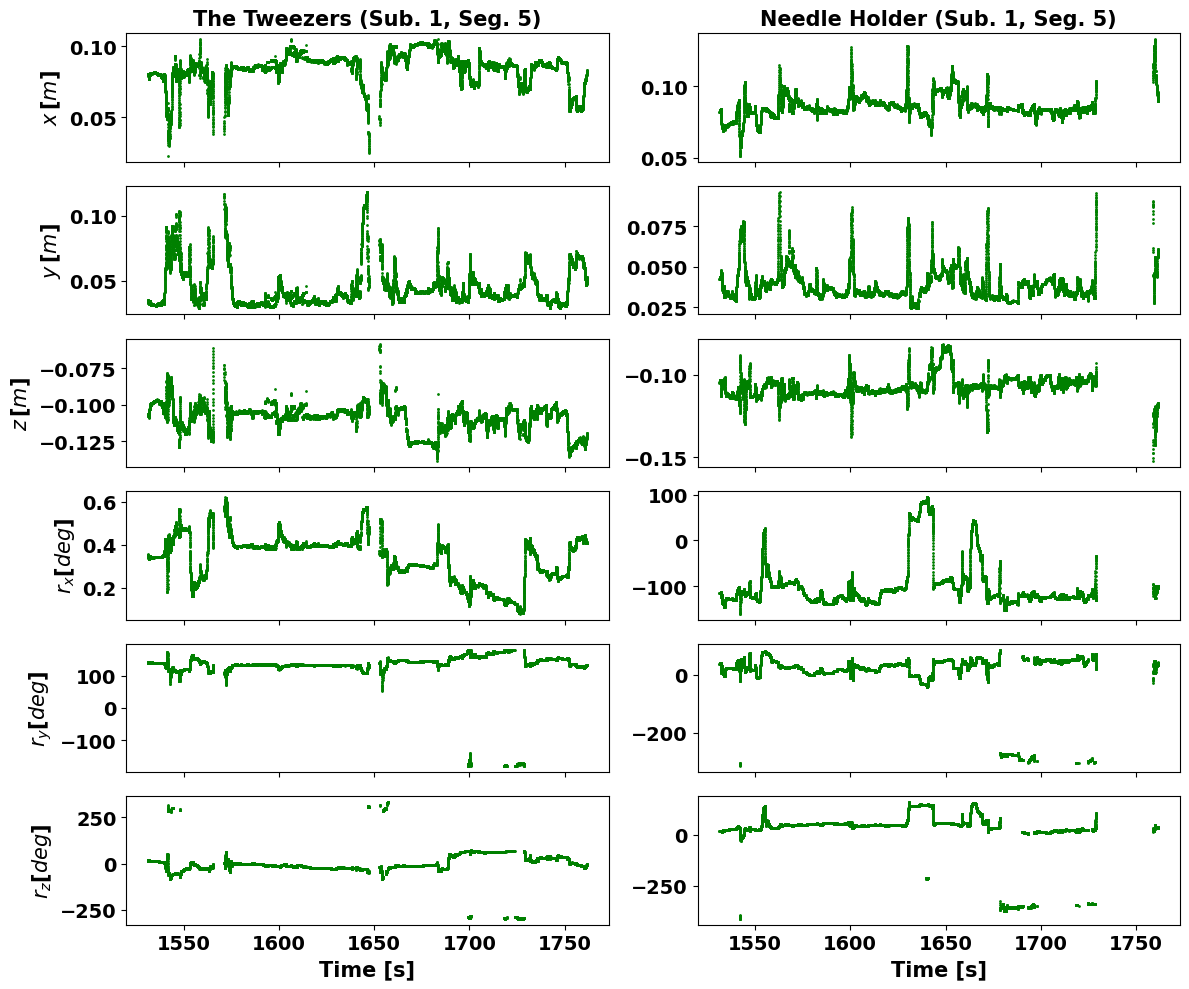

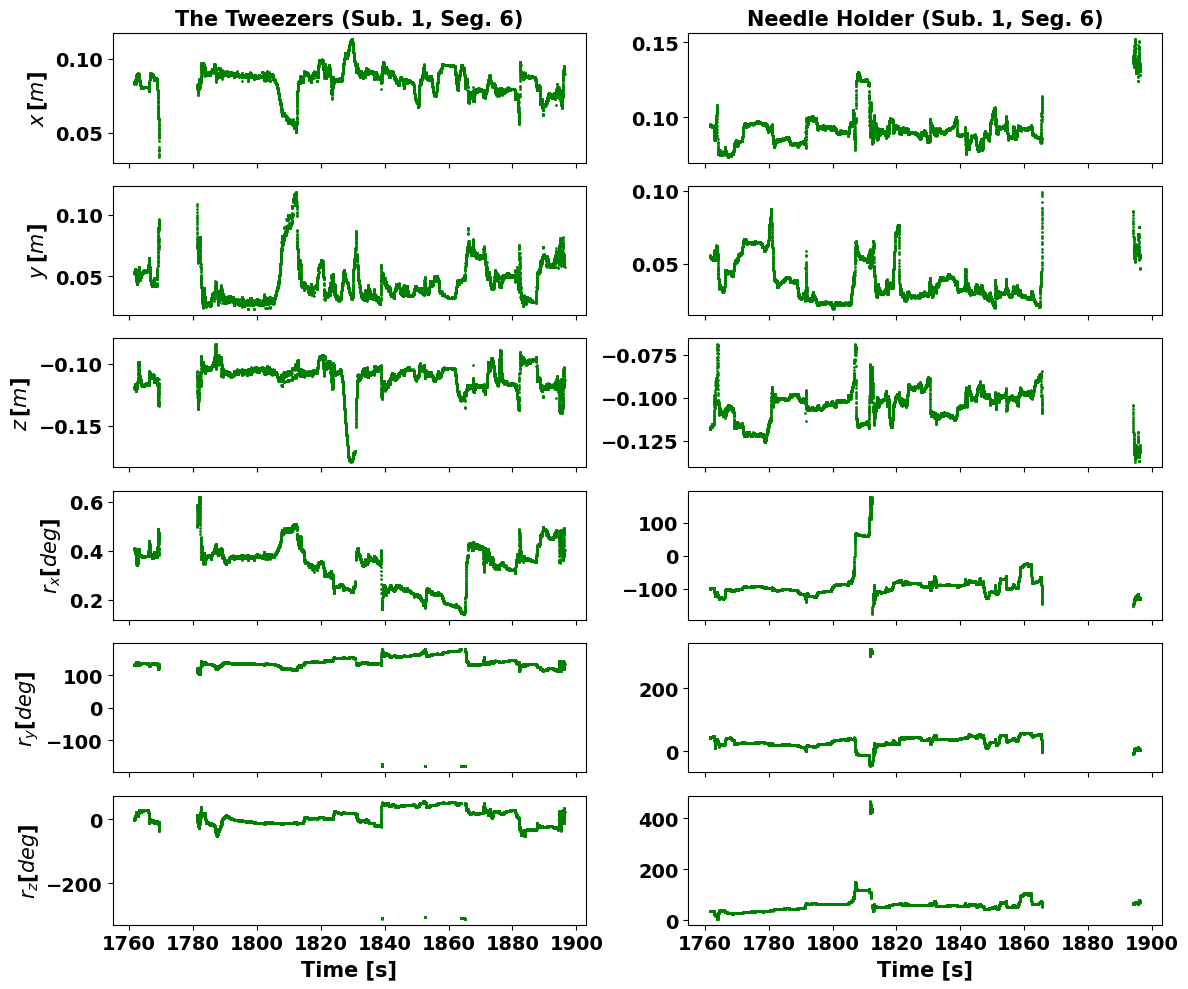

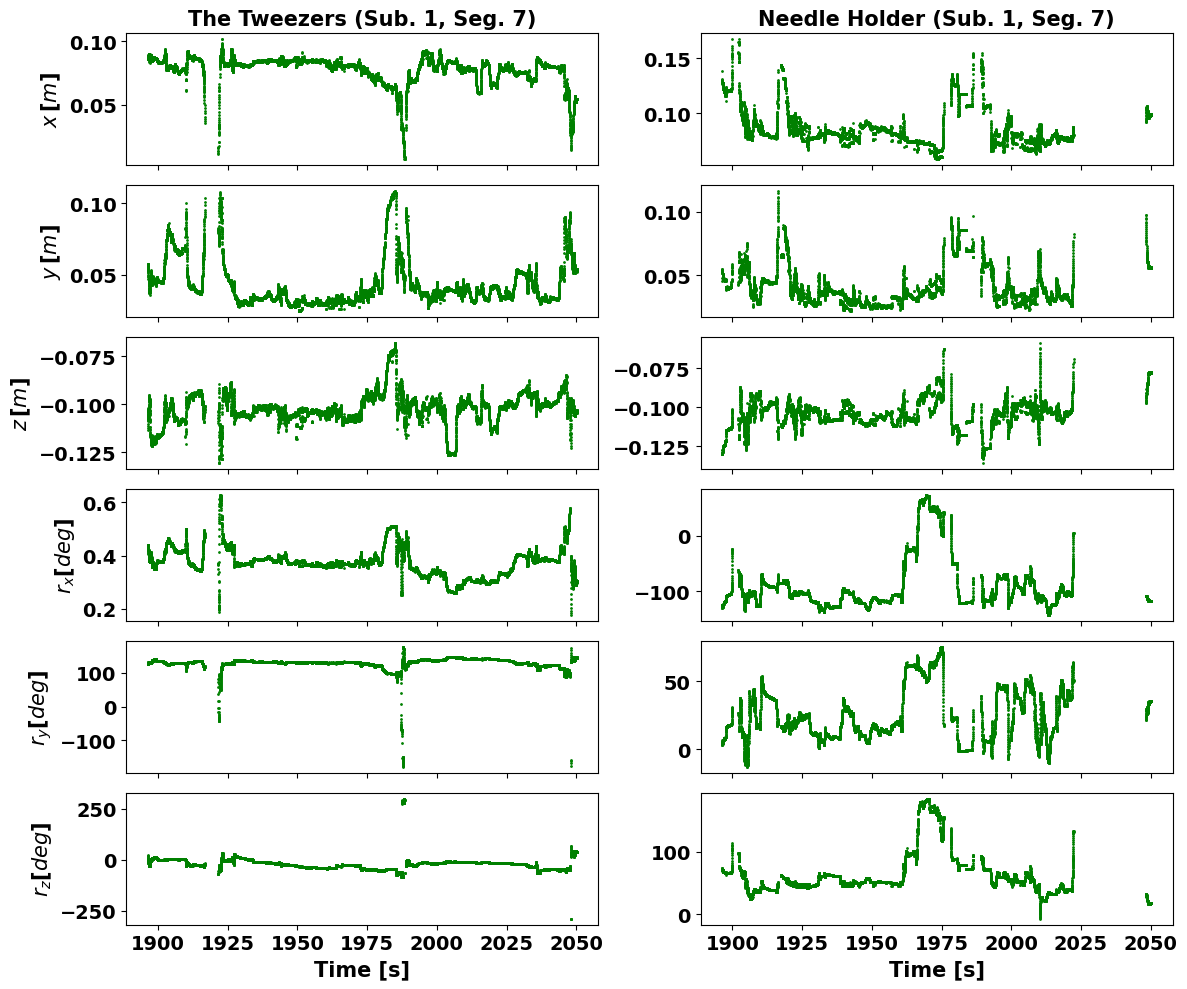

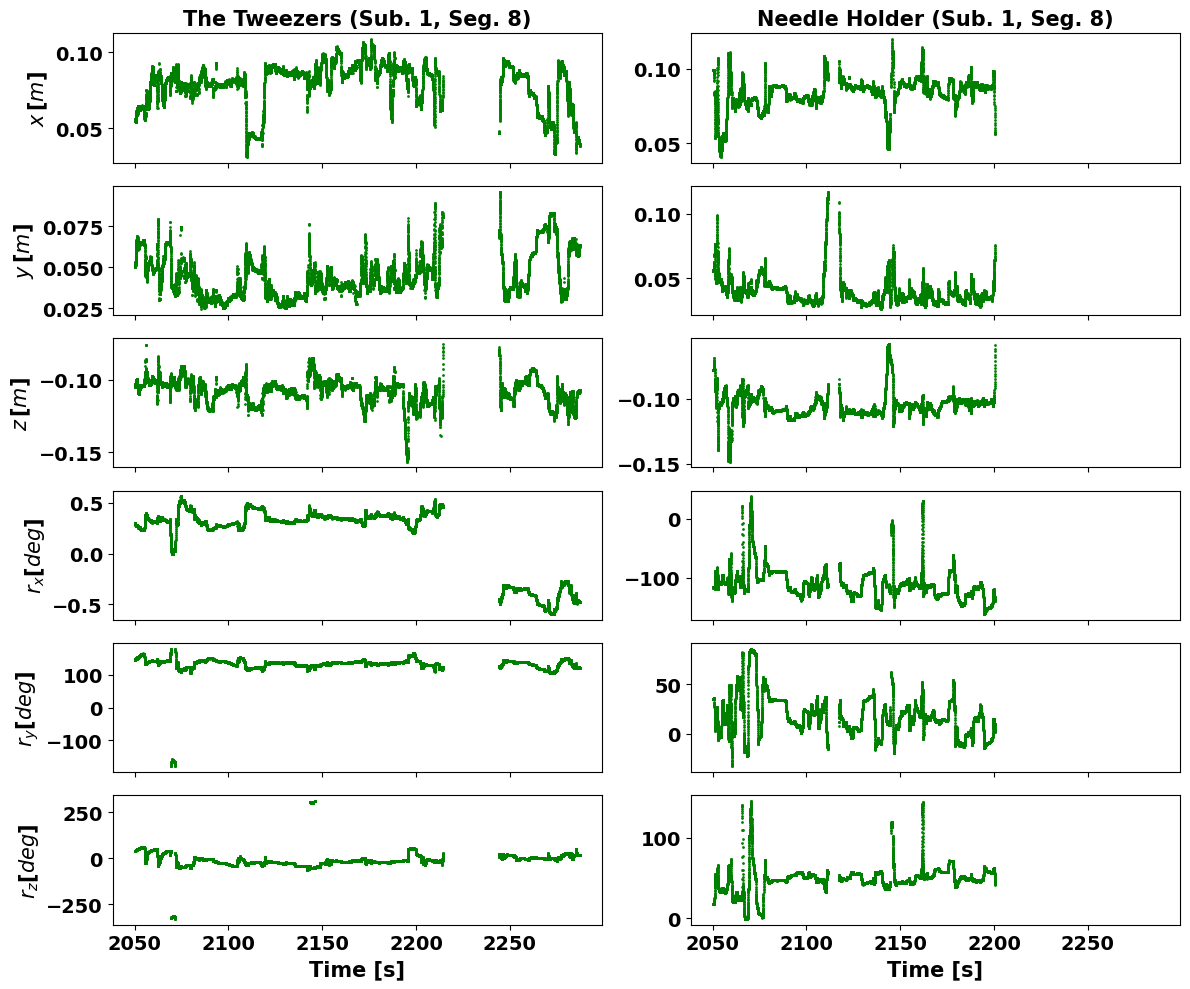

In [26]:
studied_cluster = 0 
tmp_tw = get_np_mat_specific_cluste(list_segments_with_clusters_tw, studied_cluster)
tmp_nh = get_np_mat_specific_cluste(list_segments_with_clusters_nh, studied_cluster)
plot_a_cluster_in_signal_euler(subject, tmp_tw, tmp_nh, save =False)

In [27]:
list_np_segments_d1_X_tw, list_np_segments_d2_X_tw, list_np_segments_d3_X_tw = get_list_derivatives_for_segments(list_np_segmented_tw_rec)
list_np_segments_d1_X_nh, list_np_segments_d2_X_nh, list_np_segments_d3_X_nh = get_list_derivatives_for_segments(list_np_segmented_nh_rec)

derivatives_segments_tw = [list_np_segmented_tw_rec, list_np_segments_d1_X_tw, list_np_segments_d2_X_tw, list_np_segments_d3_X_tw]
derivatives_segments_nh = [list_np_segmented_nh_rec, list_np_segments_d1_X_nh, list_np_segments_d2_X_nh, list_np_segments_d3_X_nh]

In [28]:
list_clusters_info_tw[0][0]

{'cluster_index': 0,
 'cluster_points': [[0.045004, 0.036061, -0.077057],
  [0.039145, 0.039313, -0.073113],
  [0.039779, 0.040493, -0.073563],
  [0.043396, 0.040447, -0.07636],
  [0.043941, 0.041615, -0.076606],
  [0.034158, 0.047456, -0.070567],
  [0.04321, 0.044639, -0.076328],
  [0.041499, 0.046935, -0.075583],
  [0.041479, 0.04844, -0.075991],
  [0.040185, 0.050659, -0.075586],
  [0.04066, 0.051903, -0.076199],
  [0.037922, 0.054685, -0.07528],
  [0.040198, 0.054949, -0.076597],
  [0.038959, 0.056995, -0.076249],
  [0.039524, 0.057946, -0.076688],
  [0.038749, 0.059987, -0.076451],
  [0.039255, 0.061035, -0.076798],
  [0.040653, 0.061876, -0.077063],
  [0.038029, 0.065488, -0.076356],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.07341],
  [0.028542, 0.074034, -0.073

In [89]:
def get_path_length_g(data):
    if len(data)==0:
        return np.nan
    else:
        # Calculate the differences in positions between consecutive samples
        differences = np.diff(data[:, 1:4], axis=0)
        # Calculate the Euclidean distance (path length) between consecutive points
        distances = np.linalg.norm(differences, axis=1)
        # Sum up the distances to get the total path length
        total_path_length = np.sum(distances)
        return total_path_length

In [56]:
def get_economy_of_volume_g(position, path_length):
    if ((len(position)==0) or (path_length==0)): 
        return np.nan
    else:   
        MV = 1
        for j in range(3):
            MV = MV * (np.max(position[:,j]) - np.min(position[:,j]))
        return 100.0 * ((MV ** (1/3)) / path_length)

In [82]:
def get_total_rotation_g(data):
    if len(data)==0:
        return [np.nan, np.nan, np.nan]
    else:
        angle_differences = np.diff(data, axis=0)
        total_rotations = np.sum(angle_differences, axis=0)
        return total_rotations

In [83]:
def get_mean_std_velocity_norm_g(d1_position):
    if len(d1_position)==0:
        return np.nan, np.nan
    else:
        norm_d1_position = np.linalg.norm(d1_position, axis=1)
        return np.mean(norm_d1_position), np.std(norm_d1_position)

In [91]:
def get_jerk_g(t, d1_position, d2_position, d3_position):
    if len(d1_position)==0 and len(d2_position)==0 and len(d3_position)==0:
        return np.nan
    elif len(t)==0: return np.nan
    else:
        norm_d1_position = np.linalg.norm(d1_position, axis=1)
        norm_d3_position = np.linalg.norm(d3_position, axis=1)

        norm_d1_position_max = np.max(norm_d1_position)
        frequency = 120.0
        dt = t.shape[0] * (1.0 / frequency)
        tmp = np.trapz(y=norm_d3_position**2, x=None, dx=1.0/frequency) 
        return -np.log(((dt**3) / (norm_d1_position_max**2)) * tmp)

In [90]:
def get_features(subject_id, derivatives_segments_tw, derivatives_segments_nh, 
                 list_clusters_info_tw, list_clusters_info_nh, clustering_algo, save =True):
    # just for the task cluster

    if save:
        #directory = f"{clustering_algo}/OT_Features/S_{subject_id}/"
        directory = "test_subject1/"
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
 
    NUM_OF_METRICS = 8
    NUMBER_OF_SEGMENTS = 8 
    NUMBER_OF_TOOLS = 2

    #find the maximum number of cluster
    NUMBER_OF_CLUSTERS = 1 #there is at least one cluster
    for s in range (NUMBER_OF_SEGMENTS):
        nbr_clust_tw = len(list_clusters_info_tw[s])
        nbr_clust_nh = len(list_clusters_info_nh[s])
        max_ = max(nbr_clust_tw, nbr_clust_nh)
        if max_>NUMBER_OF_CLUSTERS: NUMBER_OF_CLUSTERS=max_

    data_metrics = np.zeros((NUMBER_OF_SEGMENTS, NUMBER_OF_CLUSTERS, NUM_OF_METRICS, NUMBER_OF_TOOLS))

    for s in range(NUMBER_OF_SEGMENTS):
        unclustered_t_tw = derivatives_segments_tw[0][s][:, 0]
        unclustered_t_nh = derivatives_segments_nh[0][s][:, 0]

        unclustered_position_tw = derivatives_segments_tw[0][s][:, 1:4]
        unclustered_position_nh = derivatives_segments_nh[0][s][:, 1:4]

        unclustered_d1_position_tw = derivatives_segments_tw[1][s][:, 1:4]
        unclustered_d1_position_nh = derivatives_segments_nh[1][s][:, 1:4]
    
        unclustered_d2_position_tw = derivatives_segments_tw[2][s][:, 1:4]
        unclustered_d2_position_nh = derivatives_segments_nh[2][s][:, 1:4]
    
        unclustered_d3_position_tw = derivatives_segments_tw[3][s][:, 1:4]
        unclustered_d3_position_nh = derivatives_segments_nh[3][s][:, 1:4]

        unclustered_quaternion_tw = derivatives_segments_tw[0][s][:, 4:8]
        unclustered_quaternion_nh = derivatives_segments_nh[0][s][:, 4:8] 
        
        unclustered_euler_tw = derivatives_segments_tw[0][s][:, 8:]
        unclustered_euler_nh = derivatives_segments_nh[0][s][:, 8:] 

        
        for c in range(NUMBER_OF_CLUSTERS):
            #for c in range(number_of_clusters): #Two loops, one not used? 
            indices_tw = []
            if (c< len(list_clusters_info_tw[s])) : 
                indices_tw = list_clusters_info_tw[s][c]['cluster_indices_in_data']
            
            indices_nh = []
            if (c< len(list_clusters_info_nh[s])):
                indices_nh = list_clusters_info_nh[s][c]['cluster_indices_in_data']

            t_tw = unclustered_t_tw[indices_tw]
            t_nh = unclustered_t_nh[indices_nh]
            position_tw = unclustered_position_tw[indices_tw]
            position_nh = unclustered_position_nh[indices_nh]
            quaternion_tw = unclustered_quaternion_tw[indices_tw]
            quaternion_nh = unclustered_quaternion_nh[indices_nh]
            euler_tw = unclustered_euler_tw[indices_tw]
            euler_nh = unclustered_euler_nh[indices_nh]

            d1_position_tw = unclustered_d1_position_tw[indices_tw]
            d1_position_nh = unclustered_d1_position_nh[indices_nh]
            d2_position_tw = unclustered_d2_position_tw[indices_tw]
            d2_position_nh = unclustered_d2_position_nh[indices_nh]
            d3_position_tw = unclustered_d3_position_tw[indices_tw]
            d3_position_nh = unclustered_d3_position_nh[indices_nh]

            # path length
            path_length_tw = get_path_length_g(position_tw)
            path_length_nh = get_path_length_g(position_nh)

            # total rotation
            total_rotation_tw_x = get_total_rotation_g(euler_tw)[0]
            total_rotation_nh_x = get_total_rotation_g(euler_nh)[0]

            total_rotation_tw_y = get_total_rotation_g(euler_tw)[1]
            total_rotation_nh_y = get_total_rotation_g(euler_nh)[1]
       
            total_rotation_tw_z = get_total_rotation_g(euler_tw)[2]
            total_rotation_nh_z = get_total_rotation_g(euler_nh)[2]    

            # economy of volume
            EoV_tw = get_economy_of_volume_g(position_tw, path_length_tw)
            EoV_nh = get_economy_of_volume_g(position_nh, path_length_nh)

            # jerk
            jerk_tw = get_jerk_g(t_tw, d1_position_tw, d2_position_tw, d3_position_tw)
            jerk_nh = get_jerk_g(t_tw, d1_position_nh, d2_position_nh, d3_position_nh)

            # mean and std of d1 and d2 position
            norm_d1_position_tw_mean = get_mean_std_velocity_norm_g(d1_position_tw)[0]
            norm_d1_position_nh_mean = get_mean_std_velocity_norm_g(d1_position_nh)[0]

            data_metrics[s, c, 0, 0] = t_tw.shape[0] * (1.0 / 120.0)
            data_metrics[s, c, 0, 1] = t_nh.shape[0] * (1.0 / 120.0)

            data_metrics[s, c, 1, 0] = path_length_tw
            data_metrics[s, c, 1, 1] = path_length_nh

            data_metrics[s, c, 2, 0] = total_rotation_tw_x
            data_metrics[s, c, 2, 1] = total_rotation_nh_x

            data_metrics[s, c, 3, 0] = total_rotation_tw_y
            data_metrics[s, c, 3, 1] = total_rotation_nh_y

            data_metrics[s, c, 4, 0] = total_rotation_tw_z
            data_metrics[s, c, 4, 1] = total_rotation_nh_z

            data_metrics[s, c, 5, 0] = jerk_tw
            data_metrics[s, c, 5, 1] = jerk_nh

            data_metrics[s, c, 6, 0] = EoV_tw
            data_metrics[s, c, 6, 1] = EoV_nh

            data_metrics[s, c, 7, 0] = norm_d1_position_tw_mean
            data_metrics[s, c, 7, 1] = norm_d1_position_nh_mean

            if save: np.save(f"{directory}/ot_metrics.npy", data_metrics)
            else:
                print('Data metrics are: ') 
                print(data_metrics)

In [94]:
get_features(subject, derivatives_segments_tw, derivatives_segments_nh, list_clusters_info_tw, list_clusters_info_nh,clustering_algo='DBSCAN', save =False)

Data metrics are: 
[[[[ 3.29366667e+02  3.01033333e+02]
   [ 2.19198140e+01  1.42067080e+01]
   [ 3.36938921e+01  1.05679829e+01]
   ...
   [-3.44258343e+01 -3.57675068e+01]
   [ 4.90141443e-01  7.49468391e-01]
   [ 1.00354313e-01  8.05545400e-02]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.000000

In [101]:
with open('DBSCAN_tw_clustering.json', 'r') as f:
    tw_clusters = json.load(f)

tw_clusters

{'Subject_26': [[{'cluster_index': 0,
    'cluster_points': [[0.035504, 0.047826, -0.032081],
     [0.035097, 0.047672, -0.032769],
     [0.037605, 0.049149, -0.029131],
     [0.037683, 0.049215, -0.028919],
     [0.037917, 0.049315, -0.028703],
     [0.035705, 0.047577, -0.031573],
     [0.036134, 0.047874, -0.030994],
     [0.036072, 0.048308, -0.03108],
     [0.035415, 0.04677, -0.0313],
     [0.035431, 0.046442, -0.031295],
     [0.035569, 0.047244, -0.031632],
     [0.035696, 0.047293, -0.031668],
     [0.035972, 0.04722, -0.031395],
     [0.036008, 0.046974, -0.031773],
     [0.035816, 0.046835, -0.032049],
     [0.0359, 0.046549, -0.031631],
     [0.035802, 0.046388, -0.03226],
     [0.035624, 0.04604, -0.032325],
     [0.035736, 0.046411, -0.032126],
     [0.03557, 0.046221, -0.032141],
     [0.035365, 0.046032, -0.03218],
     [0.035485, 0.046396, -0.032448],
     [0.035237, 0.046137, -0.032489],
     [0.035276, 0.046519, -0.033039],
     [0.035376, 0.046861, -0.033206],
     

In [3]:
with open('DBSCAN_tw_clustering.json', 'r') as f:
    tw_clusters_all_sub = json.load(f)

In [7]:
for s in range (8):
    print('s',s)
    print(len(tw_clusters_all_sub['Subject_'+str(19)][s]))

s 0
4
s 1
5
s 2
4
s 3
4
s 4
5
s 5
2
s 6
4
s 7
4
